In [2]:
from typing import TypedDict, Annotated, Any, Dict
from langgraph.graph import StateGraph
import os
import warnings
from dotenv import load_dotenv
warnings.filterwarnings('ignore')
load_dotenv(override=True)

True

In [ ]:

os.environ["LANGCHAIN_PROJECT"] = "Flight Booking (MCP)"

Open weather MCP Client


In [ ]:
from langchain_mcp_adapters.client import MultiServerMCPClient

class WeatherTool:
    def __init__(self):
        self.client = None
        self.weather_tool = None

    async def setup(self):
        """Initialize MCP client + Agent once."""
        if self.client is None:
            self.client = MultiServerMCPClient(
                {
                    "weather": {
                        "url": "http://localhost:8000/mcp",
                        "transport": "streamable_http",
                    }
                }
            ) #registering a tool
            tools = await self.client.get_tools()
            print("Available tools:", [t.name for t in tools])
            # Grab the weather tool
            self.weather_tool = next((t for t in tools if t.name == "get_weather"), None)
            if self.weather_tool is None:
                raise RuntimeError("'get_weather' tool not found")

    async def get_weather(self, city: str, date: str):
        """Return weather for a given city and date."""
        if self.weather_tool is None:
            raise RuntimeError("Weather tool is not initialized. Run `await setup()` first.")
        result = await self.weather_tool.ainvoke({"city": city, "date": date})
        return result

# Example usage in a notebook:
# tool = WeatherTool()
# await tool.setup()
# weather_result = await tool.get_weather("Bangalore", "2025-08-28")
# print(weather_result)


In [5]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage


def get_weather_suggestion(weatherinfo: str):
    
    weather_info= weatherinfo
    # LLM for suggestion
    llm = ChatGroq(model="llama-3.1-8b-instant")

    system_message = SystemMessage(
    content=(
        "You are a reliable flight booking assistant. "
        "Provide clear, practical guidance on flying in the given weather. "
        "Highlight safety, risks, delays, and precautions in **maximum 4 concise bullet points**, "
        "including the city and date of travel. "
        "Ensure suggestions are actionable, trustworthy, and easy to follow."
        )
    )

    human_message = HumanMessage(
        content=(
            f"Weather forecast from OpenWeather API: {weather_info}. "
            f"First provide the city and date of travel. "
            f"Then give safety guidance for flying under these conditions, "
            f"covering risks, delays, and practical precautions in short, clear sentences."
        )
    )

     
    
    messages = [
    system_message,
    human_message
    ]
    
    response = llm.invoke(messages)
    return response.content


In [6]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from typing import Optional

class FlightState(BaseModel):
    weather_info: Optional[str]=None
    safety_advice: Optional[str]=None
    user_confirmation: Optional[str]=None
    llm_output: Optional[str]=None
    City: Optional[str]=None
    Date: Optional[str]=None
    flight_name: Optional[str]=None
    destination: Optional[str]= None
    seat_preference: Optional[str] = "Any" # Window / Aisle / Middle
    departure: Optional[str]= None    
# class Passenger_details(BaseModel):
    passenger_name: Optional[str] = None
    Gender: Optional[str] = "Male"
    Age : Optional[int]= None
    passport_number: Optional[str] = None           # ID for international flights
    contact_number: Optional[str] =  None 


In [7]:
from langgraph.pregel import Interrupt
from langgraph.types import interrupt, Command, Literal

def Human_confirmation(state: FlightState)->Command[Literal["final_confirmation"]]:
    print("Safety advice to user:\n", state.safety_advice)
    is_approved = interrupt({
        "question": "Do you want to confirm the booking?",
        "confirmation": None
    })

     # Normalize responses (yes, ok, book now → True | no, cancel → False)
    normalized = str(is_approved).strip().lower()
    confirm_words = {"yes", "ok", "book now", "confirm"}
    reject_words = {"no", "cancel", "not now"}

    if normalized in confirm_words:
        return Command(goto="get_details", update={"user_confirmation": "yes"})
    elif normalized in reject_words:
        return Command(goto="final_confirmation", update={"user_confirmation": "no"})
    else:
        # fallback → ask again
        return interrupt({"question": "Sorry, I didn’t get that. Confirm booking? (yes/no)"})

In [8]:
def get_details( flight: FlightState):
    flight.passenger_name = "Abhiram"
    flight.Age = 27
    flight.Gender = "Male"
    flight.contact_number = "989776786"
    
    flight.destination = "London"
    flight.flight_name = "Air India"
    flight.seat_preference = "Window"
    flight.departure = "10AM"
    
    return flight

In [ ]:
from langchain_core.output_parsers import StrOutputParser
llm = ChatGroq(model="llama-3.1-8b-instant")
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

# ---- new node using LLM ----
def final_llm_response(state: FlightState):
    user_conf = state.user_confirmation

    if user_conf:
        prompt = f"""
You are a helpful flight ticket booking assistant.

User reply: {{user_conf}}

If the user replies "Yes":
- First, greet the passenger with a welcome message to their airline. Example: 
  "Welcome aboard {state.flight_name} Airlines! We're excited to serve you."
- Then, generate a dummy flight ticket in a clean and professional ticket format like this:

--------------------------------------------------
                ✈ Flight Ticket ✈
--------------------------------------------------
 Passenger Name : {state.passenger_name}
 Age            : {state.Age}
 Gender         : {state.Gender}
 Contact Number : {state.contact_number}
--------------------------------------------------
 Airline        : {state.flight_name}
 Departure      : {state.departure}
 From           : {state.City}
 To             : {state.destination}
 Date           : {state.Date}
 Seat Preference: {state.seat_preference}
--------------------------------------------------
   Wishing you a safe and pleasant journey! ✈
--------------------------------------------------

If the user replies "No":
Respond politely with: 
"Thank you for using! See you again."
"""

    
        # Call LLM
        result = llm.invoke(prompt)

        # If result is a message object, get the text content
        output_text = result.content if hasattr(result, "content") else str(result)

        # Store as proper dict inside the state
        state.llm_output = {"final_confirmation": output_text}

        return state

    


In [10]:
async def Weather_prediction(state: FlightState):
    date=state.Date 
    city=state.City
    
    tool = WeatherTool()
    await tool.setup() # initializing the MCP client
    
    weather_result = await tool.get_weather(city, date)
    print(weather_result)
    state.weather_info = weather_result
    return state

def Suggetion(state: FlightState):
    weather_info=state.weather_info
    state.safety_advice= get_weather_suggestion(weather_info)
    return state

    

In [11]:


from langgraph.checkpoint.memory import MemorySaver

graph = StateGraph(FlightState)

graph.add_node("Weather_prediction",Weather_prediction)
graph.add_node("Suggetion",Suggetion)
graph.add_node("Human_confirmation", Human_confirmation)
graph.add_node("final_confirmation",final_llm_response )
graph.add_node("get_details", get_details)

graph.add_edge(START, "Weather_prediction")
graph.add_edge("Weather_prediction", "Suggetion")
graph.add_edge("Suggetion", "Human_confirmation")
graph.add_edge("Human_confirmation", "get_details")
graph.add_edge("get_details","final_confirmation")
graph.add_edge("final_confirmation", END)

memory_store = MemorySaver()
graph_final = graph.compile(checkpointer=memory_store)


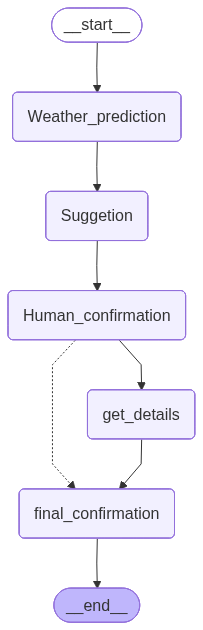

In [12]:
graph_final

In [15]:
result = await graph_final.ainvoke(
    {"City": "Bangalore", "Date": "2025-08-29"},
    config={"configurable": {"thread_id": "user4"}}
)
print(result)


Available tools: ['get_weather']
Weather in Bangalore on 2025-08-29: Overcast clouds, 19.38°C
Safety advice to user:
 **City:** Bangalore
**Date of Travel:** 2025-08-29

**Safety Guidance:**

• **Risk of Turbulence:** Flying under overcast conditions may increase the risk of turbulence, which can be severe. Be prepared for possible delays or rerouting.
• **Flight Delays:** Overcast weather can lead to reduced visibility, potentially causing flight delays or cancellations. Check with the airline for updates and plan accordingly.
• **Precautions:** Pack essential items like medication, phone chargers, and travel documents in a carry-on bag in case of unexpected delays or cancellations.
• **Stay Informed:** Regularly check the flight status and weather updates before and during your journey to ensure a smooth travel experience.
{'weather_info': 'Weather in Bangalore on 2025-08-29: Overcast clouds, 19.38°C', 'safety_advice': '**City:** Bangalore\n**Date of Travel:** 2025-08-29\n\n**Safety 

In [18]:
result = await graph_final.ainvoke(
    Command(resume="yes"),
    config={"configurable": {"thread_id": "user4"}}
)
print(result)

Safety advice to user:
 **City:** Bangalore
**Date of Travel:** 2025-08-29

**Safety Guidance:**

• **Risk of Turbulence:** Flying under overcast conditions may increase the risk of turbulence, which can be severe. Be prepared for possible delays or rerouting.
• **Flight Delays:** Overcast weather can lead to reduced visibility, potentially causing flight delays or cancellations. Check with the airline for updates and plan accordingly.
• **Precautions:** Pack essential items like medication, phone chargers, and travel documents in a carry-on bag in case of unexpected delays or cancellations.
• **Stay Informed:** Regularly check the flight status and weather updates before and during your journey to ensure a smooth travel experience.
{'weather_info': 'Weather in Bangalore on 2025-08-29: Overcast clouds, 19.38°C', 'safety_advice': '**City:** Bangalore\n**Date of Travel:** 2025-08-29\n\n**Safety Guidance:**\n\n• **Risk of Turbulence:** Flying under overcast conditions may increase the ris

In [19]:
print(result["llm_output"]["final_confirmation"])

Welcome aboard Air India Airlines! We're excited to serve you.

--------------------------------------------------
                ✈ Flight Ticket ✈
--------------------------------------------------
 Passenger Name : Abhiram
 Age            : 27
 Gender         : Male
 Contact Number : 989776786
--------------------------------------------------
 Airline        : Air India
 Departure      : 10AM
 From           : Bangalore
 To             : London
 Date           : 2025-08-29
 Seat Preference: Window
--------------------------------------------------
   Wishing you a safe and pleasant journey! ✈
--------------------------------------------------
